# brain_age

Predict age from brain grey matter (regression).
Aging is associated with is grey matter (GM) atrophy, each year, an adult lose
0.1% of GM. We will try to learn a predictor of the chronological age (true age)
using GM measurements on the brain on a population of healthy control participants.

Such a predictor provides the expected **brain age** of a subject. Deviation from
this expected brain age indicates acceleration or slowdown of the aging process
which may be associated with a pathological neurobiological process or protective factor of aging.

## Dataset

There are 357 samples in the training set and 90 samples in the test set.

### Input data

Voxel-based_morphometry [VBM](https://en.wikipedia.org/wiki/Voxel-based_morphometry)
using [cat12](http://www.neuro.uni-jena.de/cat/) software which provides:

- Regions Of Interest (`rois`) of Grey Matter (GM) scaled for the Total
  Intracranial Volume (TIV): `[train|test]_rois.csv` 284 features.

- VBM GM 3D maps or images (`vbm3d`) of [voxels](https://en.wikipedia.org/wiki/Voxel) in the
  [MNI](https://en.wikipedia.org/wiki/Talairach_coordinates) space:
  `[train|test]_vbm.npz` contains 3D images of shapes (121, 145, 121).
  This npz contains the 3D mask and the affine transformation to MNI
  referential. Masking the brain provide *flat* 331 695 input features (voxels)
  for each participant.

By default `problem.get_[train|test]_data()` return the concatenation of 284 ROIs of
Grey Matter (GM) features with 331 695 features (voxels) within a brain mask.
Those two blocks are higly redundant.
To select only on ROIs (`rois`) features do:

```
X[:, :284]
```

To select only on (`vbm`) (voxel with the brain) features do:

```
X[:, 284:]
```

### Target

The target can be found in `[test|train]_participants.csv` files, selecting the
`age` column for regression problem.

## Evaluation metrics

[sklearn metrics](https://scikit-learn.org/stable/modules/model_evaluation.html)

The main Evaluation metrics is the Root-mean-square deviation
[RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation). We will also
look at the R-squared
[R2](https://en.wikipedia.org/wiki/Coefficient_of_determination).


## Links


- [RAMP-workflow’s documentation](https://paris-saclay-cds.github.io/ramp-workflow/)
- [RAMP-workflow’s github](https://github.com/paris-saclay-cds/ramp-workflow)
- [RAMP Kits](https://github.com/ramp-kits)

## Installation

This starting kit requires Python and the following dependencies:

* `numpy`
* `scipy`
* `pandas`
* `scikit-learn`
* `matplolib`
* `seaborn`
* `jupyter`
* `ramp-workflow`

Therefore, we advise you to install [Anaconda
distribution](https://www.anaconda.com/download/) which include almost all
dependencies.

Only `nilearn` and `ramp-workflow` are not included by default in the Anaconda
distribution. They will be installed from the execution of the notebook.

To run a submission and the notebook you will need the dependencies listed in requirements.txt.
You can install the dependencies with the following command-line:

```
pip install -U -r requirements.txt
```

If you are using conda, we provide an environment.yml file for similar usage.

```
conda env create -f environment.yml
```

Then, you can activate the environment using:

```
conda activate brain_age
```

And desactivate using

```
conda deactivate
```

## Getting started

1. Download the data locally:

```
python download_data.py
```

2. Execute the jupyter notebook, from the root directory using:

```
jupyter notebook brain_age_starting_kit.ipynb
```

Tune your model using the starting_kit

3. Submission (Run locally)

The submissions need to be located in the `submissions` folder.
For instance for `linear_regression_rois`, it should be located in
`submissions/submissions/linear_regression_rois`.

Copy everything required to build your estimator in a submission file:
`submissions/submissions/linear_regression_rois/estimator.py`.
This file must contain a function `get_estimator()`.

Run locally:

```
ramp-test --submission linear_regression_rois
```

4. Submission on RAMP:

[Using RAMP starting-kits](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html)

## Descriptive statistics

age                                                         \
       count       mean        std        min        25%        50%   
set                                                                   
test    90.0  47.848019  17.852717  20.071184  31.819986  44.855578   
train  357.0  49.138846  16.095719  19.980835  35.455168  50.902122   

                             
             75%        max  
set                          
test   62.017112  82.187543  
train  62.061602  86.318960

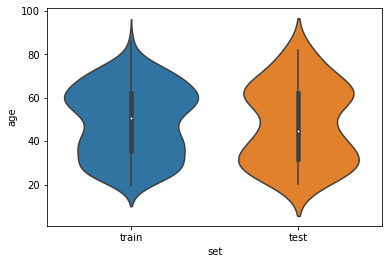

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

participants_train = pd.read_csv(os.path.join("data", "train_participants.csv" ))
participants_train["set"] = 'train'
participants_test = pd.read_csv(os.path.join("data", "test_participants.csv" ))
participants_test["set"] = 'test'
participants = participants_train.append(participants_test)

sns.violinplot(x="set", y="age", data=participants)
participants[["age", "set"]].groupby("set").describe()

## Unsupervized analysis: Explore main sources of variabilities


Load ROIs data

In [2]:
globvol_rois_train = pd.read_csv(os.path.join("data", "train_rois.csv"))
print(globvol_rois_train.iloc[:5, :10])

   participant_id     CSF_Vol      GM_Vol      WM_Vol  l3thVen_GM_Vol  \
0             651  334.031002  603.083565  560.465707        0.046239   
1             431  300.991328  603.101354  594.425495        0.052599   
2             398  252.410342  641.965684  604.320324        0.063052   
3             419  402.533442  604.978032  490.709738        0.043962   
4             627  409.460047  579.029937  509.311974        0.042226   

   r3thVen_GM_Vol  l4thVen_GM_Vol  r4thVen_GM_Vol  lAcc_GM_Vol  rAcc_GM_Vol  
0        0.052240        0.063827        0.068097     0.419533     0.427702  
1        0.047901        0.088186        0.105241     0.373451     0.377817  
2        0.051575        0.083113        0.076834     0.447264     0.465415  
3        0.041684        0.089264        0.083791     0.391540     0.388656  
4        0.036072        0.073829        0.081725     0.339043     0.358513  


`train_rois.csv` provides:

- Global volumes of "tissues": CerrebroSpinal Fluid (`CSF_Vol`), Grey (`GM_Vol`) and White Matter (`WM_Vol`) volume of participants.
- ROIs are starting at column `l3thVen_GM_Vol`. Note that `rois_train.loc[:, 'l3thVen_GM_Vol':]` matches `problem.get_train_data()[:, :284]`.

In [3]:
rois_train = globvol_rois_train.loc[:, 'l3thVen_GM_Vol':]
vols_train = globvol_rois_train.loc[:, ['CSF_Vol', 'GM_Vol', 'WM_Vol']]

### PCA on ROIs: explore global effect of age

In [4]:
from sklearn.decomposition import PCA

pca_rois = PCA(n_components=2)
PCs_rois = pca_rois.fit_transform(rois_train)
print(pca_rois.explained_variance_ratio_)

df = pd.DataFrame(dict(age=participants_train['age'], PC1_ROIs=PCs_rois[:, 0], PC2_ROIs=PCs_rois[:, 1]))

[0.54771351 0.10711543]


Main sources of variability ?


               age      PC1_ROIs      PC2_ROIs
age       1.000000  8.177015e-01 -1.108805e-01
PC1_ROIs  0.817702  1.000000e+00 -1.133611e-17
PC2_ROIs -0.110881 -1.133611e-17  1.000000e+00


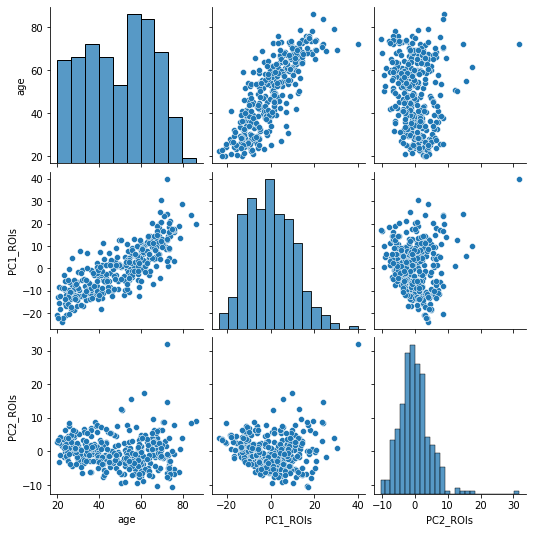

In [5]:
sns.pairplot(df)
print(df.corr())

### Neurobiological effect of age

PC1_ROIs is higlhy correlated with age Thus age seems to be the main source of variability.

Question: what is Neurobiological effect of age ? Lets explore the hypothesis of brain atrophy.

We compute brain atrophy indices:

- GM_ratio: GM_Vol / (GM_Vol + WM_Vol + CSF_Vol). It is ratio of GM in the brain.
- WM_ratio: WM_Vol / (GM_Vol + WM_Vol + CSF_Vol). It is ratio of WM in the brain.

           PC1_ROIs       age  GM_ratio  WM_ratio  CSF_ratio
PC1_ROIs   1.000000  0.817702 -0.944958 -0.467386   0.960228
age        0.817702  1.000000 -0.818380 -0.345080   0.803764
GM_ratio  -0.944958 -0.818380  1.000000  0.225909  -0.890849
WM_ratio  -0.467386 -0.345080  0.225909  1.000000  -0.643805
CSF_ratio  0.960228  0.803764 -0.890849 -0.643805   1.000000


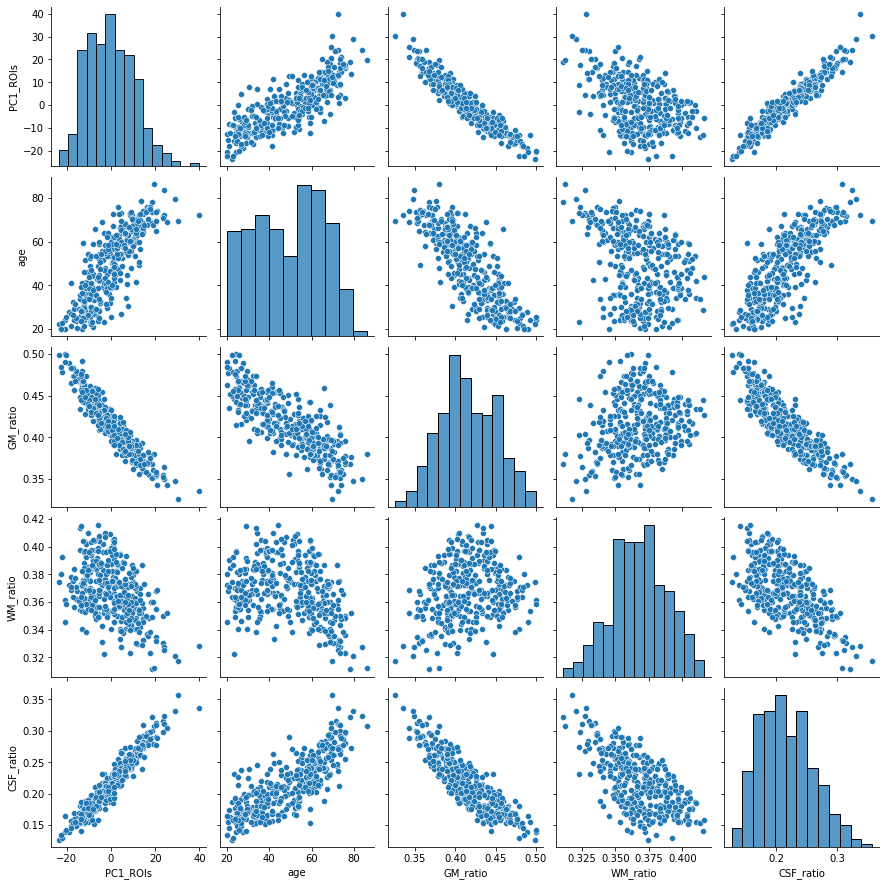

In [6]:
df["GM_ratio"] = vols_train.loc[:, "GM_Vol"] / vols_train.sum(axis=1)
df["WM_ratio"] = vols_train.loc[:, "WM_Vol"] / vols_train.sum(axis=1)
df["CSF_ratio"] = vols_train.loc[:, "CSF_Vol"] / vols_train.sum(axis=1)

sns.pairplot(df[["PC1_ROIs", "age", "GM_ratio", "WM_ratio","CSF_ratio"]])
print(df[["PC1_ROIs", "age", "GM_ratio", "WM_ratio", "CSF_ratio"]].corr())

Very strong effect on GM:
- GM_ratio correlate with PC1_ROIs
- GM_ratio correlate with age

Effect on WM:
- WM_ratio correlate with PC1_ROIs
- WM_ratio correlate with age


Aging (strongly correlates with PC1) and leads to decrease of GM_ratio and increase of CSF_ratio:

### Conclusion

**Aging leads to brain atrophy with is the main source of brain variability.
Therefore it should be possible to predict the age form the brain anatomy.**

## Machine learning


Import and read data

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
import sklearn.metrics as metrics
import problem

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

In [8]:
X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

assert X_train.shape[1] == 284 + 331695

## Utils functions

Function to compute scores

In [9]:
def cv_train_test_scores(rmse_cv_test, rmse_cv_train, r2_cv_test, r2_cv_train,
                         y_train, y_pred_train, y_test, y_pred_test):
    """Compute CV score, train and test score from a cv grid search model.

    Parameters
    ----------
    rmse_cv_test : array
        Test rmse across CV folds.
    rmse_cv_train : array
        Train rmse across CV folds.

    r2_cv_test : array
        Test R2 across CV folds.
    r2_cv_train : array
        Train R2 across CV folds.

    y_train : array
        True train values.
    y_pred_train : array
        Predicted train values.
    y_test : array
        True test values.
    y_pred_test : array
        Predicted test values.

    Returns
    -------
    info : TYPE
        DataFrame(r2_cv, r2_train, mae_train, mse_train).
    """
    # CV scores
    rmse_cv_test_mean, rmse_cv_test_sd = np.mean(rmse_cv_test), np.std(rmse_cv_test)
    rmse_cv_train_mean, rmse_cv_train_sd = np.mean(rmse_cv_train), np.std(rmse_cv_train)

    r2_cv_test_mean, r2_cv_test_sd = np.mean(r2_cv_test), np.std(r2_cv_test)
    r2_cv_train_mean, r2_cv_train_sd = np.mean(r2_cv_train), np.std(r2_cv_train)

    # Test scores
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))
    r2_test = metrics.r2_score(y_test, y_pred_test)

    # Train scores
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
    r2_train = metrics.r2_score(y_train, y_pred_train)

    
    scores = pd.DataFrame([[rmse_cv_test_mean, rmse_cv_test_sd, rmse_cv_train_mean, rmse_cv_train_sd,
                            r2_cv_test_mean, rmse_cv_test_sd, r2_cv_train_mean, r2_cv_train_sd,
                            rmse_test, r2_test, rmse_train, r2_train
                           ]],
                        columns=('rmse_cv_test_mean', 'rmse_cv_test_sd', 'rmse_cv_train_mean', 'rmse_cv_train_sd',
                                 'r2_cv_test_mean', 'rmse_cv_test_sd', 'r2_cv_train_mean', 'r2_cv_train_sd',
                                 'rmse_test', 'r2_test', 'rmse_train', 'r2_train'
                                 ))

    return scores

## Feature extractor of ROIs or voxels within the brain (VBM)

Selecting only rois or vbm images:

This can be achieved by a `ROIsFeatureExtractor` or `VBMFeatureExtractor` 

In [10]:
class ROIsFeatureExtractor(BaseEstimator, TransformerMixin):
    """Select only the 284 ROIs features:"""
    def fit(self, X, y):
        return self

    def transform(self, X):
        return X[:, :284]

class VBMFeatureExtractor(BaseEstimator, TransformerMixin):
    """Select only the 284 ROIs features:"""
    def fit(self, X, y):
        return self

    def transform(self, X):
        return X[:, 284:]


fe = ROIsFeatureExtractor()
print(fe.transform(X_train).shape)

fe = VBMFeatureExtractor()
print(fe.transform(X_train).shape)

(357, 284)
(357, 331695)


## Design of predictors and their evaluation using CV and test set

The framework is evaluated with a cross-validation approach. The metrics used are the root-mean-square error (RMSE).

First we propose a simple Regression predictor based on ROIs features only:

In [11]:
cv = problem.get_cv(X_train, y_train)

estimator = make_pipeline(ROIsFeatureExtractor(), StandardScaler(), LinearRegression())

cv_results = cross_validate(estimator, X_train, y_train, scoring=['neg_root_mean_squared_error', 'r2'], cv=cv,
                         verbose=1, return_train_score=True, n_jobs=5)

# Refit on all train
estimator.fit(X_train, y_train)
# Apply on test
y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)

print("Important scores are rmse_cv_test_mean and rmse_test")
cv_train_test_scores(rmse_cv_test=-cv_results['test_neg_root_mean_squared_error'],
                     rmse_cv_train=-cv_results['train_neg_root_mean_squared_error'],
                     r2_cv_test=cv_results['test_r2'],
                     r2_cv_train=cv_results['train_r2'],
                     y_train=y_train, y_pred_train=y_pred_train, y_test=y_test, y_pred_test=y_pred_test).T.round(3)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.9s remaining:    4.4s


Important scores are rmse_cv_test_mean and rmse_test


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    3.3s finished


,0
rmse_cv_test_mean,47.793
rmse_cv_test_sd,16.807
rmse_cv_train_mean,0.639
rmse_cv_train_sd,0.288
r2_cv_test_mean,-8.540
rmse_cv_test_sd,16.807
r2_cv_train_mean,0.998
r2_cv_train_sd,0.002
rmse_test,14.350
r2_test,0.347


Those are **really bad results:**

- Using CV **we can predict the age +- 47.8 years of error !!!**.
- Using independant test set **we can predict the age +- 14.3 years of error !!!**.

Then we test a simple Regression predictor based on vbm features:

In [12]:
estimator = make_pipeline(VBMFeatureExtractor(), StandardScaler(), LinearRegression())

cv = problem.get_cv(X_train, y_train)

cv_results = cross_validate(estimator, X_train, y_train, scoring=['neg_root_mean_squared_error', 'r2'], cv=cv,
                         verbose=1, return_train_score=True, n_jobs=5)

cv_train_test_scores(rmse_cv_test=-cv_results['test_neg_root_mean_squared_error'],
                     rmse_cv_train=-cv_results['train_neg_root_mean_squared_error'],
                     r2_cv_test=cv_results['test_r2'],
                     r2_cv_train=cv_results['train_r2'],
                     y_train=y_train, y_pred_train=y_pred_train, y_test=y_test, y_pred_test=y_pred_test).T.round(3)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   54.6s remaining:  1.4min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   54.9s finished


,0
rmse_cv_test_mean,6.968
rmse_cv_test_sd,0.623
rmse_cv_train_mean,0.000
rmse_cv_train_sd,0.000
r2_cv_test_mean,0.808
rmse_cv_test_sd,0.623
r2_cv_train_mean,1.000
r2_cv_train_sd,0.000
rmse_test,14.350
r2_test,0.347


Using CV **we can predict the age +- 7 years of error**. But using an independant test set **we can predict the age +- 14.3 years of error !!!**.
Your turn to do better !

## Submission

The submissions need to be located in the submissions folder. For instance for `linear_regression_rois`, it should be located in `submissions/submissions/linear_regression_rois`.

Copy everything required (the cell bellow) to build your estimator in a submission file: `submissions/submissions/linear_regression_rois/estimator.py`. This file must contain a function `get_estimator()`:

In [13]:
import numpy as np

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


class ROIsFeatureExtractor(BaseEstimator, TransformerMixin):
    """Select only the 284 ROIs features:"""
    def fit(self, X, y):
        return self

    def transform(self, X):
        return X[:, :284]


def get_estimator():
    """Build your estimator here."""
    estimator = make_pipeline(ROIsFeatureExtractor(), StandardScaler(),
                              LinearRegression())
    return estimator

Run locally:
    
```
ramp-test --submission linear_regression_rois
```

Submission on RAMP:

[Using RAMP starting-kits](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html)